In [87]:
def parse(prog: str):
    res = []
    for l in prog.strip().splitlines():
        action, rest = l.split(" ", 1)
        if action == "inp":
            res.append(("inp", (rest)))
        else:
            a,b = rest.split(" ")
            if b in ("w","x", "y", "z"):
                res.append((action+"_var", (a,b)))
            else:
                res.append((action+"_val", (a,int(b))))
    return tuple(res)

class ALU():
    def __init__(self, prog) -> None:
        self.reset()
        self.inp = []
        self.prog = prog        
        
    def _inp(self, a):
        if len(self.inp) == 0:
            return True
        self.state[a] = self.inp.pop()

    def _add_var(self, a,b):
        self.state[a] += self.state[b]
    def _add_val(self, a,b):
        self.state[a] += b

    def _mul_var(self, a,b):
        self.state[a] *= self.state[b]
    def _mul_val(self, a,b):
        self.state[a] *= b

    def _div_var(self, a,b):
        self.state[a] //= self.state[b]
    def _div_val(self, a,b):
        self.state[a] //= b

    def _mod_var(self, a,b):
        self.state[a] %= self.state[b]
    def _mod_val(self, a,b):
        self.state[a] %= b

    def _eql_var(self, a,b):
        self.state[a] = 1 if self.state[a] == self.state[b] else 0
    def _eql_val(self, a,b):
        self.state[a] = 1 if self.state[a] == b else 0
                
                
    def setInp(self, inp: str):
        self.inp = list(map(int, inp))[::-1]

    def run(self):
        for i, (ins, args) in enumerate(self.prog):
            pause = getattr(self, "_"+ins)(*args)
            if pause:
                self.i = i
                return self.state

        return self.state
        
        
    def reset(self):
        self.state = {
            "w": 0,
            "x": 0,
            "y": 0,
            "z": 0
        }
        self.i = 0

def newALU(base: ALU) -> ALU:
    res = ALU("")
    res.prog = base.prog
    res.state = {k: v for k,v in base.state.items()}
    res.i = base.i

In [88]:
negate = ALU(parse("""inp x
mul x -1"""))
negate.setInp("7")
negate.run()

{'w': 0, 'x': -7, 'y': 0, 'z': 0}

In [89]:
times3 = ALU(parse("""inp z
inp x
mul z 3
eql z x"""))
times3.setInp("38")
print(times3.run())
times3.reset()
times3.setInp("39")
times3.run()

{'w': 0, 'x': 8, 'y': 0, 'z': 0}


{'w': 0, 'x': 9, 'y': 0, 'z': 1}

In [72]:
binary = ALU(parse("""inp w
add z w
mod z 2
div w 2
add y w
mod y 2
div w 2
add x w
mod x 2
div w 2
mod w 2"""))
binary.setInp("7")
binary.run()

{'w': 0, 'x': 1, 'y': 1, 'z': 1}

In [53]:
with open("data/24.txt") as f:
    pzl = f.read()

monad = ALU(pzl)
monad.setInp("13579246899999")
monad.run()

{'w': 9, 'x': 1, 'y': 18, 'z': 172660766}

In [67]:
def run(prog, inp: str, known, d=0):
    a = ALU(prog)
    if inp in known:
        a.i = known[inp]["i"]
        a.state = known[inp]["state"]
    


def part1(inp):
    known = {}
    prog = parse(inp)
    monad = ALU(prog)
    for inp in range(int(1e14-1), int(1e13), -1):
        s = str(inp)
        if '0' in s:
            continue
        monad.reset()
        monad.setInp(s)
        monad.run()
        if monad.state["z"] == 0:
            return s
            

In [153]:
def inp(i, s: dict, a, nex):
    s[a] = int(nex)
    return i+1, s

def add_var(i,s, a,b):
    s[a] += s[b]
    return i+1, s
def add_val(i,s, a,b):
    s[a] += b
    return i+1, s

def mul_var(i,s, a,b):
    s[a] *= s[b]
    return i+1, s
def mul_val(i,s, a,b):
    s[a] *= b
    return i+1, s

def div_var(i,s, a,b):
    s[a] //= s[b]
    return i+1, s
def div_val(i,s, a,b):
    s[a] //= b
    return i+1, s

def mod_var(i,s, a,b):
    s[a] %= s[b]
    return i+1, s
def mod_val(i,s, a,b):
    s[a] %= b
    return i+1, s

def eql_var(i,s, a,b):
    s[a] = 1 if s[a] == s[b] else 0
    return i+1, s
def eql_val(i,s, a,b):
    s[a] = 1 if s[a] == b else 0
    return i+1, s

funcs = {
    "inp": inp,
    "add_var": add_var,
    "add_val": add_val,
    "mul_var": mul_var,
    "mul_val": mul_val,
    "div_var": div_var,
    "div_val": div_val,
    "mod_var": mod_var,
    "mod_val": mod_val,
    "eql_var": eql_var,
    "eql_val": eql_val,
}

from functools import cache

@cache
def run(i, s, prog, inp):
    s = {
        "w": 0,
        "x": 0,
        "y": 0,
        "z": s,
    }
    while i < len(prog):
        inst = prog[i]
        if inst[0] == "inp":
            if len(inp) == 0:
                return i, s["z"]
            i, s = funcs["inp"](i,s, inst[1][0], inp[0])
            inp = inp[1:]
        else:
            i, s = funcs[inst[0]](i,s, *inst[1])
    return i, s["z"]

@cache
def next_states(i, s, prog):
    if i == len(prog):
        return s
    ss = set()
    for n in "987654321":
        new_i, new_s = run(i, s, prog, n)
        ss.add(new_s)
    return new_i, ss

In [158]:
run(18, 0, prog, "3")

(36, 13)

In [152]:
def next_inp(i,s, prog, inp):
    i, s = run(i,s, prog, inp[-1])
    if s > 1e6:
        return False, -1
    if len(inp) == 14:
        return i == len(prog) and s == 0, inp
    for n in "987654321":
        val, num = next_inp(i,s, prog, inp+n)
        if val:
            return val, num
    return False, -1



def part1(raw):
    prog = parse(raw)
    i = 0
    for n in "987654321":
        val, num = next_inp(0, 0, prog, n)
        if val:
            return num


part1(pzl)


KeyboardInterrupt: 

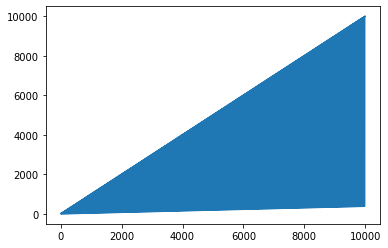

In [183]:
prog = parse(pzl)
from itertools import product
res = {}
# for n in product("987654321", repeat=6):
#     _, s = run(0, empty(), prog, n)
#     res[int("".join(n))] = s[3]

for n in range(10000):
    _, s = run(3*18, n, prog, "7")
    res[n] = s
import matplotlib.pylab as plt

lists = sorted(res.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()


In [173]:
[i for i,v in enumerate(prog) if v[0] == "inp"]

[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234]